# Text-to-Query Agents with MongoDB and LangGraph

**Run the cell below to install the necessary libraries.**

In [1]:
# !pip install -q langchain-openai==0.3.28 langgraph==0.6.3 pymongo==4.13.2 langchain-mongodb==0.6.2 langgraph-checkpoint-mongodb

In [2]:
import os
from pymongo import MongoClient
from langchain_mongodb.agent_toolkit.database import MongoDBDatabase
from langchain_mongodb.agent_toolkit.toolkit import MongoDBDatabaseToolkit
from langchain_openai import ChatOpenAI

MONGODB_URI = "write_your_own_mongodb_uri"
OPENAI_API_KEY = "write_your_own_openai_api_key"

mongodb_client = MongoClient(MONGODB_URI)

# Access the sample_mflix database using the MongoDBDatabase class
db = MongoDBDatabase.from_connection_string(connection_string=MONGODB_URI, database="sample_mflix")

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=OPENAI_API_KEY
)

# Initialize the MongoDB database toolkit
toolkit = MongoDBDatabaseToolkit(db=db, llm=llm)

# Extract the tools from the toolkit
tools = toolkit.get_tools()

# Map tool names to tool objects
tool_map = {tool.name:tool for tool in tools}

### Create LLM prompt

In addition to a prebuilt set of tools, the MongoDB database toolkit also provides an LLM system prompt containing instructions on how to generate MongoDB queries from natural language, and also guidance on how to use the tools available in the toolkit.

We will use this as the system prompt for the LLM in our text-to-query agent.

**Import and preview the prebuilt `MONGODB_AGENT_SYSTEM_PROMPT` to get a feel for the instructions.**

In [3]:
from langchain_mongodb.agent_toolkit import MONGODB_AGENT_SYSTEM_PROMPT

# Preview the system prompt
MONGODB_AGENT_SYSTEM_PROMPT

'You are an agent designed to interact with a MongoDB database.\nGiven an input question, create a syntactically correct MongoDB query to run, then look at the results of the query and return the answer.\nUnless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.\nYou can order the results by a relevant field to return the most interesting examples in the database.\nNever query for all the fields from a specific collection, only ask for the relevant fields given the question.\n\nYou have access to tools for interacting with the database.\nOnly use the below tools. Only use the information returned by the below tools to construct your final answer.\nYou MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.\n\nDO NOT make any update, insert, or delete operations.\n\nThe query MUST include the collection name and the contents of the aggregation pi

Notice that this system prompt takes a `top_k` variable to specify the default number of results to return. We will pre-fill this rather than it being user-specified.

In addition to the `MONGODB_AGENT_SYSTEM_PROMPT`, we will provide some more additional system instructions to the LLM. We will also need to create a placeholder to pass user messages, tool outcomes, chat history etc. to the LLM.
Let's do this using the `ChatPromptTemplate` class.

**Define a prompt template containing `MONGODB_AGENT_SYSTEM_PROMPT` to instruct the text-to-query agent on how to use the tools provided.**

In [4]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Create a templated prompt for the LLM
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", MONGODB_AGENT_SYSTEM_PROMPT),
        ("system", """IMPORTANT: Always start by checking your memory for relevant information before calling any tools.
        Always wrap _id in quotes when generating queries. 
        Do not re-run tools unless absolutely necessary. 
        If you are not able to get enough information using the tools, 
        reply with I DON'T KNOW. 
        You have access to the following tools: {tool_names}."""),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

You can partially fill certain variables in prompt templates if you have access to them before others using the `partial` method in LangChain.

Let's set the value of `top_k` in the `MONGODB_AGENT_SYSTEM_PROMPT` to 5 to return the top 5 results from a query by default, and the `tool_names` in the custom system prompt to a comma separated list of the tools present in the MongoDB database toolkit.

In [5]:
# Pre-fill top_k and tool_names in the prompt template
prompt = prompt.partial(top_k=5, tool_names=", ".join([tool.name for tool in tools]))

### Bind tools to the LLM

Next, let's give the `llm` access to the tools. To do this, we will use the `.bind_tools()` method in LangChain.

**Bind the tools with the OpenAI LLM.**

In [6]:
# Bind tools to the LLM
tool_augmented_llm = llm.bind_tools(tools)

**Chain the `prompt` to the `tool_augmented_llm` using the `|` operator.**

In [7]:
# Chain the prompt and tool-augmented LLM
llm_with_tools = prompt | tool_augmented_llm

# Test the llm_with_tools chain
llm_with_tools.invoke({"messages": [("user", "Give me the top 5 directors by IMDB rating, who have made more than 20 movies")]}).tool_calls

[{'name': 'mongodb_list_collections',
  'args': {},
  'id': 'call_qqT2eqkhYRSAdsWqXk1sgLj2',
  'type': 'tool_call'}]

The above test shows that the LLM will first call the `mongodb_list_collections` tool, given a user query.

This is exactly what we want the agent to do as the first step in executing a text-to-query workflow.

Next, let's use the tools from before and the tool-augmented LLM to create the nodes of our agent's graph.

# Orchestrating the text-to-query agent

With the tools and prompt created, we are finally ready to orchestrate the text-to-query agent.

We will use LangGraph for agent orchestration. With LangGraph, you can orchestrate LLM applications as graphs. Graphs in LangGraph have three main components, namely nodes, edges and state.

Nodes help you define the main logic of the graph, edges help define the flow of the graph, and the state is a shared data structure between all the nodes.

### Define graph state

First, let's define the state of our agent's graph.

To do this, we will use the `GraphState` class in LangGraph. In our case, the class will have only one attribute i.e. `messages` to track user and AI messages, but you can have additional attributes to track other information that you want the nodes in your graphs to share.

**Define the graph state using the `GraphState` class, with a single attribute called `messages`.**

In [8]:
from typing import Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

class GraphState(TypedDict):
    messages: Annotated[list, add_messages]

Notice the type of the `messages` attribute: `Annotated[list, add_messages]`. This indicates that `messages` is a list and new messages are appended to it using the pre-built `add_messages` reducer function available in LangGraph.

Next, we will create the nodes of the graph, one of them being an agent node which uses a tool-augmented LLM to decide what actions to take.

However, we haven't yet given the LLM we initialized previously access the tools we created. We'd also want to give the LLM instructions on how to use these tools.

So let's do this before proceeding to create the nodes of the graph.

### Define graph nodes

Our text-to-query agent will have two nodes, an agent node, and a tool node.

Given a user query, it is first routed to the agent node which uses the tool-augmented LLM to decide the next action.

If the LLM decides to call a tool, the tool invocation payload is written to the graph's state. An example of what this looks like is as follows:
```
[{'name': 'mongodb_list_collections',
  'args': {},
  'id': 'call_qHNWqi22CP3Gqc8kdJbqv2Wy',
  'type': 'tool_call'}]
```
When the LLM decides that it has the final answer, it is also written to the graph state, and can be read from there to return to the user. We will see how later in the project.

**Define the agent node that reads the `'messages'` attribute of the graph state, invokes the `llm_with_tools` with the messages, and appends the result to the `'messages'` attribute of the graph state.**

In [9]:
# Define the agent node
def agent_node(state):
    # Read "messages" from the graph state
    messages = state["messages"]
    # Invoke the tool-augmented LLM to determine next action
    result = llm_with_tools.invoke(messages)
    # Append the result to the graph state
    return {"messages": [result]}

**Define the tool node that reads the `.tool_calls` attribute of the most recent message in the graph state, extracts the name of the tool to execute (`"name"`), invokes it with the arguments (`"args"`) of the tool call, and appends the result to the `"messages"` attribute of the graph state.**

In [10]:
# Define the tool node
from langchain_core.messages import ToolMessage

def tool_node(state: GraphState):
    result = []
    # Read the tool invocation payload from the graph state
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        # Extract the name of the tool to execute
        tool = tool_map[tool_call["name"]]
        # Invoke the tool with the arguments extracted from the payload
        observation = tool.invoke(tool_call["args"])
        # Create a ToolMessage to log the result of the tool execution
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    # Append the result to the graph state
    return {"messages": result}

If the LLM decides to call a tool, the control is passed to the tool node, which does the following:
* Reads the tool invocation payload from the graph state
* Executes the tool call with the arguments from the payload
* Writes the outcome from the tool call back to the graph state

In LangChain, there are  different types of `Messages` to distinguish between user, AI, tool messages etc. The `ToolMessage` object is specifically used to pass the result of tool execution back to a model.

### Build the graph

Now, let's connect the nodes and edges to build the graph for our text-to-query agent.

**Initialize the graph using the `StateGraph` class in LangGraph, with the graph state (`GraphState`) we defined previously.**

In [11]:
from langgraph.graph import StateGraph

# Initialize the graph with graph state
graph = StateGraph(GraphState)

In our text-to-query agent, we have fixed edges from the `START` node to `agent`, and from `tools` to `agent`. Then, we have conditional edges from `agent`to `tools` and `END`.

We will add fixed edges using the `.add_edge()` method in LangGraph. This method takes the source and target nodes, identified by their node IDs, as inputs.

For conditional edges, we will use the `.add_conditional_edges()` method with the pre-built `tools_condition` function in LangGraph that allows you to define the conditional routing logic.

**Add the nodes and edges (both fixed and conditional) to the graph.**

In [12]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition

# Add a node called "agent" that calls the agent_node() function
graph.add_node("agent", agent_node)
# Add a node called "tools" that calls the tool_node() function
graph.add_node("tools", tool_node)

# Add a fixed edge from the START node to the "agent" node
graph.add_edge(START, "agent")
# Add a fixed edge from the "tool" node to the "agent" node
graph.add_edge("tools", "agent")
# Add conditional edges from the "agent" node to the "tool" and "END" nodes
graph.add_conditional_edges(
    "agent",
    tools_condition,
    {"tools": "tools", END: END},
)

Finally, let's compile the graph using the `.compile()` method in LangGraph.

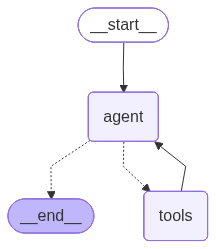

In [13]:
# Compile and visualize the graph
app = graph.compile()
app

### Test the agent

Finally, let's test out the agent with some sample queries.

Let's write a helper function to print the agent outputs nicely. We will stream the outputs from the agent as they produced using the `.stream()` method in LangGraph, and we will use the `.pretty_print()` method which formats the messages to make them more readable.

In [14]:
def execute_graph(user_input: str) -> None:
    """
    Stream outputs from the graph

    Args:
        user_input (str): User query string
    """
    # Stream outputs from each step in the graph
    for step in app.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        # Stream full value of the state after each step
        stream_mode="values",
    ):
        # Print the latest message from the step
        step["messages"][-1].pretty_print()

execute_graph("Give me the top 5 directors by IMDB rating, who have made at least 20 movies")

================================ Human Message =================================

Give me the top 5 directors by IMDB rating, who have made at least 20 movies
================================== Ai Message ==================================
Tool Calls:
  mongodb_list_collections (call_HUr6Gwhk61YKiSDsXOwxoQzw)
 Call ID: call_HUr6Gwhk61YKiSDsXOwxoQzw
  Args:
================================= Tool Message =================================

comments, embedded_movies, movies, sessions, theaters, users
================================== Ai Message ==================================
Tool Calls:
  mongodb_schema (call_8bpqN6EaODN3jJJQqNxmZRSW)
 Call ID: call_8bpqN6EaODN3jJJQqNxmZRSW
  Args:
    collection_names: movies
================================= Tool Message =================================

Database name: sample_mflix
Collection name: movies
Schema from a sample of documents from the collection:
_id: ObjectId
plot: String
genres: Array<String>
runtime: Number
cast: Array<String>
poste

Using the above test, we can clearly see the steps taken by our text-to-query agent to arrive at an answer, including what tools were called, the arguments of the tool calls etc.

# Adding memory to the agent

In this section, we will add short-term memory to our text-to-query agent. Short-term memory allows AI agents to have multi-turn conversations with its users. We will use MongoDB to persist the agent's short-term memory. We will use MongoDB's checkpointer integration with LangGraph (`MongoDBSaver`) to automatically handle the memory management for the agent.

**Initialize a MongoDBSaver object using the `mongodb_client` and compile the graph using it.**

In [15]:
from langgraph.checkpoint.mongodb import MongoDBSaver

checkpointer = MongoDBSaver(mongodb_client)

app = graph.compile(checkpointer=checkpointer)

The agent execution function looks similar to what we had before, except it takes an additional argument, `thread_id`.

The `thread_id` is used by the MongoDB checkpointer to retrieve the latest checkpoint for the current conversational thread upon each invocation, and write new checkpoints to MongoDB after each node execution.

To configure the thread ID, you need to create a runtime config specifying the `thread_id` and pass it as an argument while invoking the graph.

**Using the `execute_graph_with_memory()` helper function and the `thread_id` provided, find which states have the most theaters.**

In [16]:
def execute_graph_with_memory(thread_id: str, user_input: str) -> None:
  """
    Execute the memory-augmented agent

    Args:
        thread_id (str): Thread ID for which to retrieve memory
        user_input (str): User query
    """
  # Configure the thread ID
  config = {"configurable": {"thread_id": thread_id}}
  # Stream outputs from each step in the graph
  for step in app.stream(
      {"messages": [{"role": "user", "content": user_input}]},
      config,
      stream_mode="values",
  ):
      # Print the latest message from the step
      step["messages"][-1].pretty_print()

In [17]:
from uuid import uuid4

thread_id = str(uuid4())
execute_graph_with_memory(thread_id, "Which states have the most theaters?")

================================ Human Message =================================

Which states have the most theaters?
================================== Ai Message ==================================
Tool Calls:
  mongodb_list_collections (call_oDIxRUpbPHcxxKHqp6JP8Oyq)
 Call ID: call_oDIxRUpbPHcxxKHqp6JP8Oyq
  Args:
================================= Tool Message =================================

comments, embedded_movies, movies, sessions, theaters, users
================================== Ai Message ==================================
Tool Calls:
  mongodb_schema (call_I3wMLDbJv2MeHBkVBggBjxGq)
 Call ID: call_I3wMLDbJv2MeHBkVBggBjxGq
  Args:
    collection_names: theaters
================================= Tool Message =================================

Database name: sample_mflix
Collection name: theaters
Schema from a sample of documents from the collection:
_id: ObjectId
theaterId: Number
location.address.street1: String
location.address.city: String
location.address.state: String


In [18]:
execute_graph_with_memory(thread_id, "How many theaters does California have?")

================================ Human Message =================================

How many theaters does California have?
================================== Ai Message ==================================
Tool Calls:
  mongodb_query_checker (call_uGkNA3j78M7EEx14wf8edgAX)
 Call ID: call_uGkNA3j78M7EEx14wf8edgAX
  Args:
    query: db.theaters.aggregate([ { "$match": { "$expr": { "$eq": [ "$location.address.state", "CA" ] } } }, { "$count": "theaterCount" } ])
================================= Tool Message =================================

content='```javascript\ndb.theaters.aggregate([ { "$match": { "$expr": { "$eq": [ "$location.address.state", "CA" ] } } }, { "$count": "theaterCount" } ])\n```' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 137, 'total_tokens': 182, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_det

**Retrieve the checkpoint from the `thread_id` and run a new query.**

In [20]:
# Reset agent to a specific checkpoint
config = {"configurable": {"thread_id": thread_id}}
checkpointer.get(config)
app = graph.compile(checkpointer=checkpointer)

execute_graph_with_memory(thread_id, "How many theaters does California have?")

# import pprint

# # List and analyze checkpoints
# pprint.pprint(list(checkpointer.list(config, limit=5)))


================================ Human Message =================================

How many theaters does California have?
================================== Ai Message ==================================

California has a total of **169 theaters**.


Notice that the agent did not make any new tool calls but instead used information from its short-term memory to answer the question.

There is so much more you can do with checkpoints in LangGraph. Here are some ideas:
* Analyze successful agent trajectories
* Debug erroneous agent trajectories
* Reset the agent to a previous state
* Modify information in a previous state